In [97]:
%pip install langgraph langchain langchain_openai langchain_community
%pip install -q langfuse

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [98]:
import os, getpass
import json

from typing import TypedDict, List, Optional, Dict, Any
from IPython.display import Image, display

from langfuse import Langfuse
from langfuse.callback import CallbackHandler

from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

In [99]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("LANGFUSE_PUBLIC_KEY")
_set_env("LANGFUSE_SECRET_KEY")
_set_env("LANGFUSE_HOST")

langfuse = Langfuse(
  secret_key=os.environ["LANGFUSE_SECRET_KEY"],
  public_key=os.environ["LANGFUSE_PUBLIC_KEY"],
  host=os.environ["LANGFUSE_HOST"]
)

langfuse_handler = CallbackHandler()

In [100]:
class Draft(TypedDict):
    title: str
    body: str
    images: List[str]

class State(MessagesState):
    prompt: str
    topic: str
    sources: Optional[List[Dict[str, Any]]]
    reason: Optional[List[str]]
    draft: str

In [101]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7,
    streaming=True,
    verbose=True,
    callbacks=[langfuse_handler],
)

tavily = TavilySearchResults(max_results=5)

In [102]:
def get_user_prompt_node(state: State) -> State:
    '''
    Get the user prompt node.
    '''
    prompt = input(
        "Inserisci il prompt per l'articolo: "
    )
    return { "prompt": prompt }

In [103]:
def extract_topic_node(state: State) -> State:
    '''
    Extract the topic from the user prompt.
    '''
    
    prompt = f'''
    The user provided the following input:

    "{state["prompt"]}"
    Your task is to extract the main topic of the article that the user wants to write.
    The topic should be a single word or a short phrase that summarizes the main idea of the article.

    For example, if the user prompt is "How to train a dog", the topic would be "dog training".

    If the user prompt is "The history of the internet", the topic would be "internet history".

    Only return the topic.
    '''

    print(f"Prompt: {prompt}")

    response = llm.invoke(prompt)

    print(f"Response: {response}")
    
    topic = response.content.strip()
    return { "topic": topic }

In [104]:
def search_sources_node(state: State) -> State:
    '''
    Use Tavily to search for high-quality sources based on the topic.
    Filters results with score > 0.7 and keeps structured data.
    '''
    
    results = tavily.invoke({ "query": state["topic"] })

    formatted_results = [
        {
            "title": r.get("title", ""),
            "url": r.get("url", ""),
            "content": r.get("content", ""),
            "score": r.get("score", 0),
        }
        for r in results if r.get("score", 0) > 0.7
    ]

    return { "sources": formatted_results }   

In [105]:
def generate_draft_node(state: State) -> State:
    '''
    Generate a draft for the article based on the topic and sources.
    '''

    urls = [r["url"] for r in state["sources"] if "url" in r]
    sources = "\n".join(urls)
    
    prompt = f'''
    Write a detailed article about the topic: "{state["topic"]}". 

    Use **ONLY** the exact information contained in the following sources, and do not add anything that is not directly supported by them. 
    The article should strictly reflect the facts as they are presented in the sources without any additional assumptions or unverified details:
    {sources}

    Make sure to mention the exact dates and details from the sources, without adding any speculative or external information. 
    The tone should be formal, informative, and objective.
    '''

    response = llm.invoke(prompt)
    draft = response.content.strip()
    return { "draft": draft }

In [ ]:
def verify_article_node(state: State) -> State:
    '''
    Verify that the article only contains information supported by the sources.
    Return the verification result and (if not verified) the reason why.
    '''
    
    urls = [r["url"] for r in state["sources"] if "url" in r]
    sources = "\n".join(urls)

    prompt = f'''
    You are a fact-checking assistant. Below is an article and the sources it claims to be based on.

    SOURCES:
    {sources}

    ARTICLE:
    {state["draft"]}

    Question: Does the article reflect the general accuracy and key points presented in the sources, 
    even if some details might not be explicitly mentioned or slightly inferred?

    Answer YES or NO. 
    If NO, please explain which claims might not be fully supported by the sources and provide suggestions for a more accurate representation of the sources. 
    Focus on the overall accuracy of the article, not on minor details.
    '''

    response = llm.invoke(prompt)
    content = response.content.strip()
    
    is_verified = "yes" in content.lower().split("\n")[0]

    return {
        "reason": None if is_verified else content,
        "verified": is_verified,
    }

In [107]:
builder = StateGraph(State)
builder.add_node("get_user_prompt", get_user_prompt_node)
builder.add_node("extract_topic", extract_topic_node)
builder.add_node("search_sources", search_sources_node)
builder.add_node("generate_draft", generate_draft_node)
builder.add_node("verify_article", verify_article_node)

builder.add_edge(START, "get_user_prompt")
builder.add_edge("get_user_prompt", "extract_topic")
builder.add_edge("extract_topic", "search_sources")
builder.add_edge("search_sources", "generate_draft")
builder.add_edge("generate_draft", "verify_article")
builder.add_edge("verify_article", END)

graph = builder.compile().with_config(
    callbacks=[langfuse_handler],
)

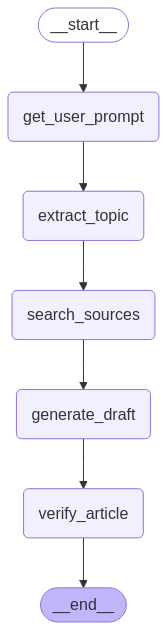

In [108]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [109]:
graph.invoke({})

Prompt: 
    The user provided the following input:

    "Scrivi un articolo sulla PS5 Pro"
    Your task is to extract the main topic of the article that the user wants to write.
    The topic should be a single word or a short phrase that summarizes the main idea of the article.

    For example, if the user prompt is "How to train a dog", the topic would be "dog training".

    If the user prompt is "The history of the internet", the topic would be "internet history".

    Only return the topic.
    
Response: content='PS5 Pro' additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a'} id='run-d3004a03-d944-40b2-b5f6-3a2dd0a65429-0'


{'messages': [],
 'prompt': 'Scrivi un articolo sulla PS5 Pro',
 'topic': 'PS5 Pro',
 'sources': [{'title': 'Buy PlayStation®5 Pro Console | PlayStation® (US) | See Price',
   'url': 'https://direct.playstation.com/en-us/buy-consoles/playstation5-pro-console',
   'content': 'PS5® Pro is an all-digital console with no disc drive. Sign into your account for PlayStation™Network and go to PlayStation™Store to buy and download games**. You can also add a Disc Drive*** to your PS5® Pro console if you would like to play PS5 or PS4 games on Blu-ray™ Disc, or if you want to watch movies and shows on 4K Ultra HD Blu-ray™ Discs, Blu-ray™ Discs, and DVDs.\n- less\nCurrently Unavailable\nLow stock\nComing Soon\nSign In to Buy\nCurrently Unavailable\nAdd PS Plus Required [...] With the PlayStation®5 Pro console, the world’s greatest game creators can enhance their games with incredible features like advanced ray tracing, super sharp image clarity for your 4K TV, and high frame rate gameplay*. That m